# Training our Neural Network

Our NN in the previous lesson still doesn't correctly classify the input images. 

When training our neural network we provide the input image with the correct label and the Neural Network will approximate the function that maps the input with the output. The power of neural networks is that we can perform this type of training, given enough data and compute time.

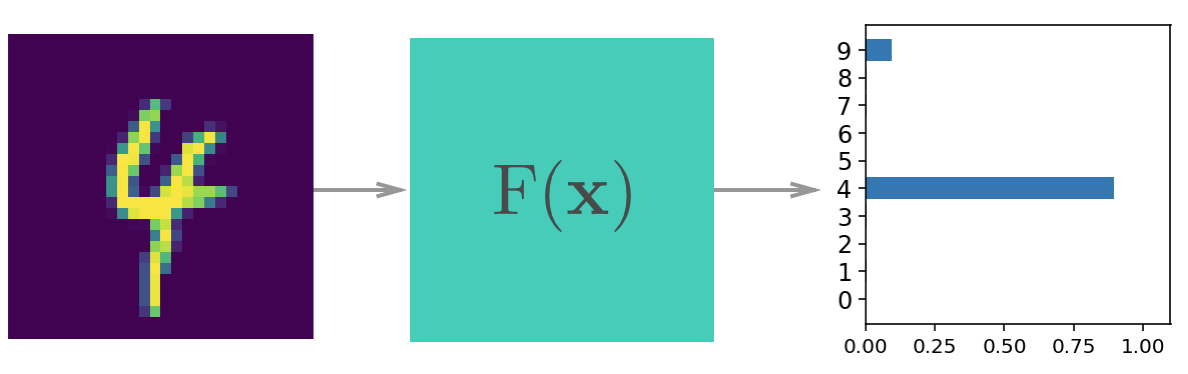

We train the network by providing samples of real data, then adjusting the network parameters such that it approximates this function.

To find these parameters, we need to know how poorly the model is predicting real outputs. For this, we calculate a loss function (or cost function) which is a measure of our prediction error. *Cross-entropy* is preferred for classifaction, while *mean squared error* is often used in logistic regression and binary classification problems:

$$\ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}$$

where $n$ is the number of training examples, $y_i$ are the true labels, and $\hat{y}_i$ are the predicted labels.

By minimizing this loss (by tweaking the network parameters), we can find configurations where the loss is at a minimum and the network is able to correctly predict labels with high accuracy. We find this minimum using *gradient descent* (or other optimisation functions).

## Backpropagation

More specifically the loss is reduced by calculating the parameters (weights) which are updated by the optimisation function (i.e. SGD, Adam, etc), which propagates these values backwards through the network, and then fed forward again (using an optimiser step), calculate the loss again and repeat, until the minima for the model is found.

Mathematically, this is really just calculating the gradient of the loss with respect to the weights using the chain rule.

$$\frac{\partial \ell}{\partial w_1} = \frac{\partial l_1}{\partial w_1} \frac{\partial s}{\partial l_1} \frac{\partial l_2}{\partial s} \frac{\partial \ell}{\partial l_2}$$

We update our weights using this gradient with some learning rate $\alpha$. 

$$w^\prime = w - \alpha \frac{\partial \ell}{\partial w}$$

The learning rate is set such that the weight update steps are small enough that the iterative method settles in a minimum.

## Setting Loss and Optimiser functions in PyTorch

To define our loss function is PyTorch we use ```criterion```. In our NN we're using a Softmax function, so we want to use criterion = nn.CrossEntropyLoss() as our loss function. When training we use ```loss = criterion(output, targets)``` to calculate the actual loss of our model.

We also need to define the optimizer function, in this case we'll be using Stochastic Gradient Descent (SGD), passing in the network parameters and the learning rates to it.

### Autograd

Torch provides a module called ```autograd```, for automatically calculating the gradient of tensors. It does this by keeping track of operations performed on ternsors. To make sure PyTorch keeps track of operations on a tensor and  calculates the gradients, we need to set ```requires_grad``` when creating it, or at anytime using ```x.requires_grad(True)```

To turn off gradients for a block of code, we use ```torch.no_grad()```

```python
x = torch.zeros(1, requires_grad=True)
>>> with torch.no_grad():
...     y = x * 2
>>> y.requires_grad
False
```

Also, you can turn on or off gradients altogether with `torch.set_grad_enabled(True|False)`.

The gradients are computed with respect to some variable, i.e. `z` with `z.backward()`. This does a backward pass through the operations that created `z`.

## Training in PyTorch

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from collections import OrderedDict

import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import helper
!conda install pytorch -c pytorch -y

Solving environment: done

# All requested packages already installed.



In [31]:
## Examples First
x = torch.randn(2,2, requires_grad=True)
x

tensor([[ 3.8738, -0.2123],
        [-0.8812,  1.1690]])

In [32]:
y = x**2
y

tensor([[ 15.0064,   0.0451],
        [  0.7766,   1.3665]])

In [33]:
## show the function that generated this variable
print(y.grad_fn)

The autgrad module keeps track of these operations and knows how to calculate the gradient for each one. In this way, it's able to calculate the gradients for a chain of operations, with respect to any one tensor. Let's reduce the tensor _y_ to a scalar value, the mean.

In [34]:
z = y.mean()
z

tensor(4.2986)

In [35]:
print(x.grad)

None


In [36]:
z.backward()
print(x.grad)
print(x/2)

tensor([[ 1.9369, -0.1061],
        [-0.4406,  0.5845]])
tensor([[ 1.9369, -0.1061],
        [-0.4406,  0.5845]])


For training we need the gradients of the weights with respect to the cost. With PyTorch, we run data forward through the network to calculate the cost, then, go backwards to calculate the gradients with respect to the cost. Once we have the gradients we can make a gradient descent step.

## Training in Action

##### Resuming work on our network from previous notebook

## 1. Get the Data

Let's build a similar network to the one in the previous notebook, using nn.sequential. We won't be using softmax on the output, instead just using raw output from the last layer. This is because the output from softmax is a probability distribution. Often, the output will have values really close to zero or really close to one. Due to [inaccuracies with representing numbers as floating points](https://docs.python.org/3/tutorial/floatingpoint.html), computations with a softmax output can lose accuracy and become unstable. To get around this, we'll use the raw output, called the **logits**, to calculate the loss.

## 2. Create the Network

In [39]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(input_size, hidden_sizes[0])),
    ('relu1', nn.ReLU()),
    ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
    ('relu2', nn.ReLU()),
    ('logits', nn.Linear(hidden_sizes[1], output_size))
]))
model

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (logits): Linear(in_features=64, out_features=10, bias=True)
)

## 3. Train the Network!

In [48]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

#### 3.1 Intuition about this step

First, let's consider just one learning step before looping through all the data. The general process with PyTorch:

    - Make a forward pass through the network to get the logits
    - Use the logits to calculate the loss
    - Perform a backward pass through the network with loss.backward() to calculate the gradients
    - Take a step with the optimizer to update the weights

Below we'll go through one training step and print out the weights and gradients to understand the process under the hood.

In [56]:
# In real practice this becomes an iterable process

print('Initial Weights - ', model.fc1.weight) # Network is initialised with random weights

images, labels = next(iter(trainloader))
images.resize_(64, 784)

optimizer.zero_grad() # to avoid accumulating the gradients everytime backward() is run

#Forward pass
output = model.forward(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient', model.fc1.weight.grad)
optimizer.step()

Initial Weights -  Parameter containing:
tensor([[ 2.8272e-02, -2.7461e-03, -1.3004e-02,  ..., -1.7986e-02,
          8.4528e-03,  1.1737e-02],
        [-1.3500e-02, -1.4648e-02,  1.7902e-02,  ...,  5.7611e-04,
          2.5702e-02, -1.4915e-03],
        [-2.7714e-02, -1.0953e-02, -3.4795e-02,  ..., -1.2547e-02,
          2.0642e-03, -4.7642e-03],
        ...,
        [-1.7535e-02,  5.9621e-03, -2.6880e-02,  ...,  2.0749e-02,
         -1.2623e-02, -3.2173e-03],
        [-1.4427e-02,  2.1288e-02,  2.3145e-02,  ...,  4.0464e-04,
         -8.2733e-03, -2.7808e-02],
        [-1.5026e-02,  1.8396e-02,  3.1574e-02,  ..., -2.2484e-02,
          1.0555e-02, -1.1676e-03]])
Gradient tensor(1.00000e-02 *
       [[ 0.1332,  0.1332,  0.1332,  ...,  0.1332,  0.1332,  0.1332],
        [ 0.0526,  0.0526,  0.0526,  ...,  0.0526,  0.0526,  0.0526],
        [ 0.7879,  0.7879,  0.7879,  ...,  0.7879,  0.7879,  0.7879],
        ...,
        [ 0.1188,  0.1188,  0.1188,  ...,  0.1188,  0.1188,  0.1188],
    

In [54]:
print('Updated weights - ', model.fc1.weight)

Updated weights -  Parameter containing:
tensor([[ 2.8272e-02, -2.7461e-03, -1.3004e-02,  ..., -1.7986e-02,
          8.4528e-03,  1.1737e-02],
        [-1.3500e-02, -1.4648e-02,  1.7902e-02,  ...,  5.7611e-04,
          2.5702e-02, -1.4915e-03],
        [-2.7714e-02, -1.0953e-02, -3.4795e-02,  ..., -1.2547e-02,
          2.0642e-03, -4.7642e-03],
        ...,
        [-1.7535e-02,  5.9621e-03, -2.6880e-02,  ...,  2.0749e-02,
         -1.2623e-02, -3.2173e-03],
        [-1.4427e-02,  2.1288e-02,  2.3145e-02,  ...,  4.0464e-04,
         -8.2733e-03, -2.7808e-02],
        [-1.5026e-02,  1.8396e-02,  3.1574e-02,  ..., -2.2484e-02,
          1.0555e-02, -1.1676e-03]])


In [60]:
### 3.2 Training for Real
epochs = 3
print_every = 40
steps = 0

for e in range(epochs):
    running_loss = 0
    for images, labels in iter(trainloader):
        steps +=1
        # Flatten in-place MNIST Images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        # Forward Pass
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every))
            
            running_loss = 0

Epoch: 1/3... Loss: 2.2538
Epoch: 1/3... Loss: 2.1657
Epoch: 1/3... Loss: 2.0462
Epoch: 1/3... Loss: 1.8635
Epoch: 1/3... Loss: 1.6440
Epoch: 1/3... Loss: 1.4401
Epoch: 1/3... Loss: 1.2438
Epoch: 1/3... Loss: 1.0889
Epoch: 1/3... Loss: 0.9658
Epoch: 1/3... Loss: 0.8540
Epoch: 1/3... Loss: 0.7831
Epoch: 1/3... Loss: 0.6940
Epoch: 1/3... Loss: 0.6550
Epoch: 1/3... Loss: 0.6280
Epoch: 1/3... Loss: 0.6013
Epoch: 1/3... Loss: 0.5429
Epoch: 1/3... Loss: 0.5545
Epoch: 1/3... Loss: 0.4981
Epoch: 1/3... Loss: 0.4986
Epoch: 1/3... Loss: 0.4986
Epoch: 1/3... Loss: 0.4694
Epoch: 1/3... Loss: 0.4576
Epoch: 1/3... Loss: 0.4360
Epoch: 2/3... Loss: 0.2191
Epoch: 2/3... Loss: 0.4405
Epoch: 2/3... Loss: 0.4239
Epoch: 2/3... Loss: 0.4102
Epoch: 2/3... Loss: 0.3773
Epoch: 2/3... Loss: 0.3937
Epoch: 2/3... Loss: 0.4061
Epoch: 2/3... Loss: 0.3972
Epoch: 2/3... Loss: 0.3760
Epoch: 2/3... Loss: 0.4035
Epoch: 2/3... Loss: 0.3682
Epoch: 2/3... Loss: 0.3826
Epoch: 2/3... Loss: 0.3984
Epoch: 2/3... Loss: 0.4108
E

## 4. Test Predictions

After we have trained the network, we test with data it has never seen before. This will normally give us an indication of how accurate the predictions are.

In [ ]:
images, labels = next(iter(trainloader))

img = images[0].view(1,784)

logits = model.forward(img)

ps = F.softmax(logits, dim=1)
helper.view_classify(img.view(1,28,28), ps)

## 5. Save checkpoint

As we don't want to be training our network everytime we want to use it, we create checkpoints, where the state_dict is saved and then loaded. During this step is also a good idea to save the Network Architecture and other important details about our implementation.

I'll expand on this and remaining points on another notebooks.

## 6. Inference and Validation

After the network is trained, it can be used to make predictions on new data. This is typically called Inference. Neural Networks tend to perform really well on test data but aren't able to generalise to data that have not seen before. This is called **overfitting** and it impairs inference performance.

In [67]:
### End of Lesson